# **Tutorial 5**


## **Imports**

In [1]:
import numpy as np # arrays, array operations
import scipy.stats as stats # statistics
from google.colab import files
import matplotlib.pyplot as plt # plot graphs
import pandas as pd #dataframes
import io
import xarray as xr #multidimensional dataframes
import pymc as pm
import arviz as az
import seaborn as sns

#preliz
!pip install preliz
import preliz as pz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 16.4 MB/s eta 0:00:00


## Gaussian Distribution

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

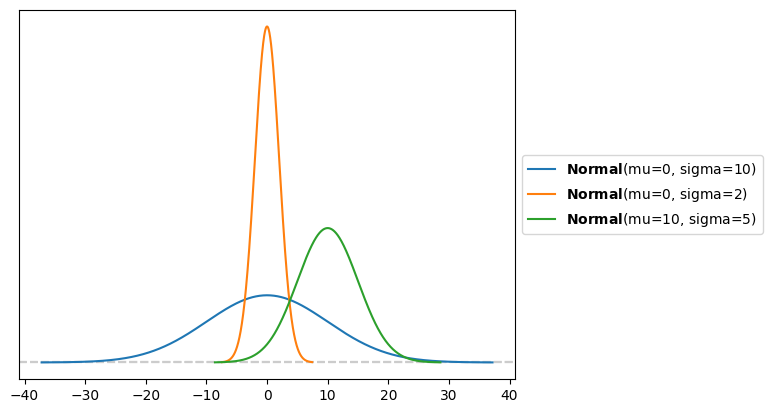

In [ ]:
#some examples
mu = 0
sigma = 10
normal_dist = pz.Normal(mu, sigma)
normal_dist.plot_pdf()

mu = 0
sigma = 2
normal_dist = pz.Normal(mu, sigma)
normal_dist.plot_pdf()

mu = 10
sigma = 5
normal_dist = pz.Normal(mu, sigma)
normal_dist.plot_pdf()

plt.savefig("norm.png", bbox_inches='tight')
files.download("norm.png")

## Collect Data


In [ ]:
#installs for reading the google sheets
!pip install --upgrade gspread
!pip install --upgrade oauth2client
!pip install --upgrade gspread google-auth oauth2client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 6.1.4
    Uninstalling gspread-6.1.4:
      Successfully uninstalled gspread-6.1.4


In [ ]:
#authentication
from google.colab import auth
from google.auth.transport.requests import Request
import gspread
from google.auth import default

# Authenticate the user
auth.authenticate_user()

# Get the credentials
creds, _ = default()

# Authorize gspread with the credentials
gc = gspread.authorize(creds)

In [ ]:
#getting our assignment time collected data
# Open the spreadsheet by its ID
spreadsheet_id = '1dN65TMREKA88He7xTTNGwTWJYY7MnP9KKqR2MbC3OSI'  # Replace with your own spreadsheet ID
worksheet = gc.open_by_key(spreadsheet_id).sheet1

# Read all records into a DataFrame
data = worksheet.get_all_records()
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

,Timestamp,How long does it take you to do a Statistics homework assignment in minutes?
0,3/16/2025 16:59:23,210


Data

In [ ]:
#collected
data = df['How long does it take you to do a Statistics homework assignment in minutes?'].to_numpy()
print(data)


[210]


In [2]:
#simulated
data = stats.t.rvs(df=2, loc=120, scale=5, size=30)


Plot Data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

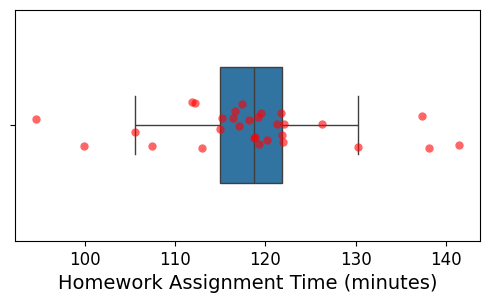

In [3]:
fig = plt.figure(figsize = (6, 3))
sns.boxplot(data, width=0.5, showfliers=False, orient = 'h')
sns.stripplot(data=data, size=6, jitter=True, color="red", alpha=0.6, orient = 'h')

plt.xlabel('Homework Assignment Time (minutes)', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("data.png", bbox_inches='tight')
files.download("data.png")

## PyMC Normal Model

Priors

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

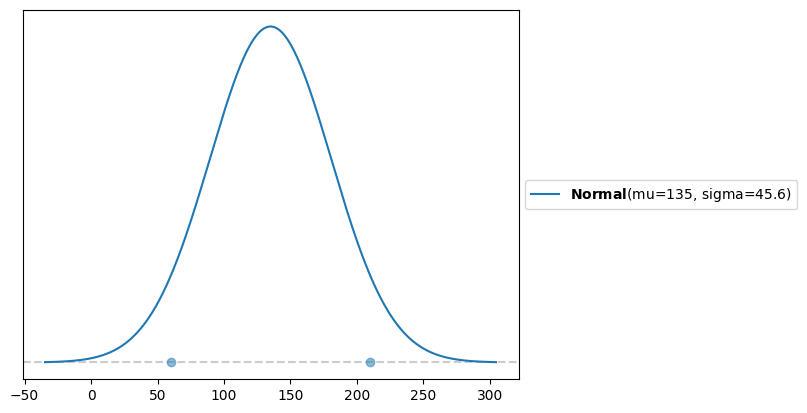

In [9]:
#mu
dist = pz.Normal()
pz.maxent(dist, 60, 210, 0.9)
mu_prior = dist.mu
sig_prior = dist.sigma

plt.savefig("mu_prior.png", bbox_inches='tight')
files.download("mu_prior.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

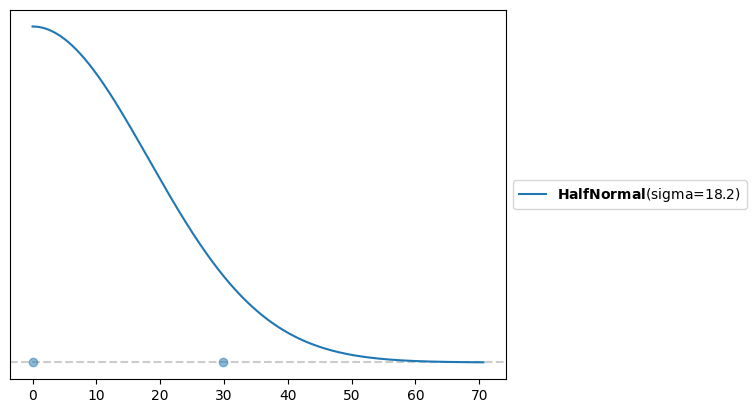

In [8]:
#sigma
dist = pz.HalfNormal()
pz.maxent(dist, 0, 3*np.std(data, ddof = 1), 0.9)
sigma_prior = dist.sigma

plt.savefig("sigma_prior.png", bbox_inches='tight')
files.download("sigma_prior.png")

Model

In [6]:
coords = {"data": np.arange(len(data))}

with pm.Model(coords = coords) as model_g:
  m = pm.Normal('m', mu = mu_prior, sigma = sig_prior)
  sig = pm.HalfNormal('sig', sigma = sigma_prior)
  Y = pm.Normal('Y', mu=m, sigma=sig, observed=data, dims = 'data')
  idata_g = pm.sample(1000, chains = 4)

Posterior

In [ ]:
idata_g

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

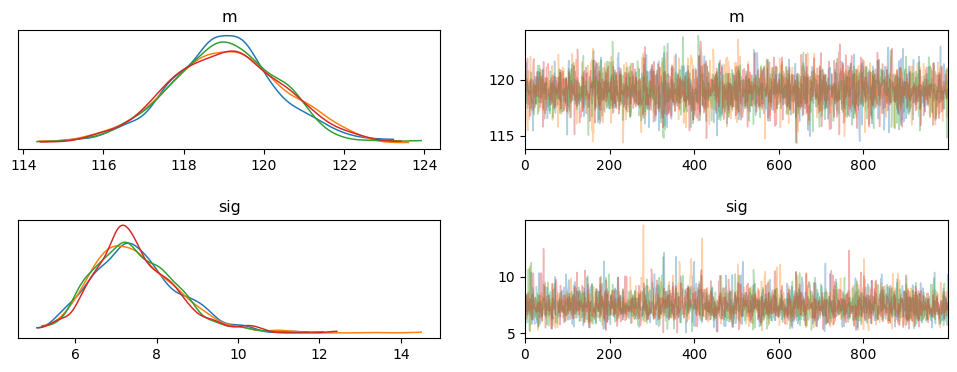

In [ ]:

az.plot_trace(idata_g, compact = False)
plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots

plt.savefig("trace.png", bbox_inches='tight')
files.download("trace.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

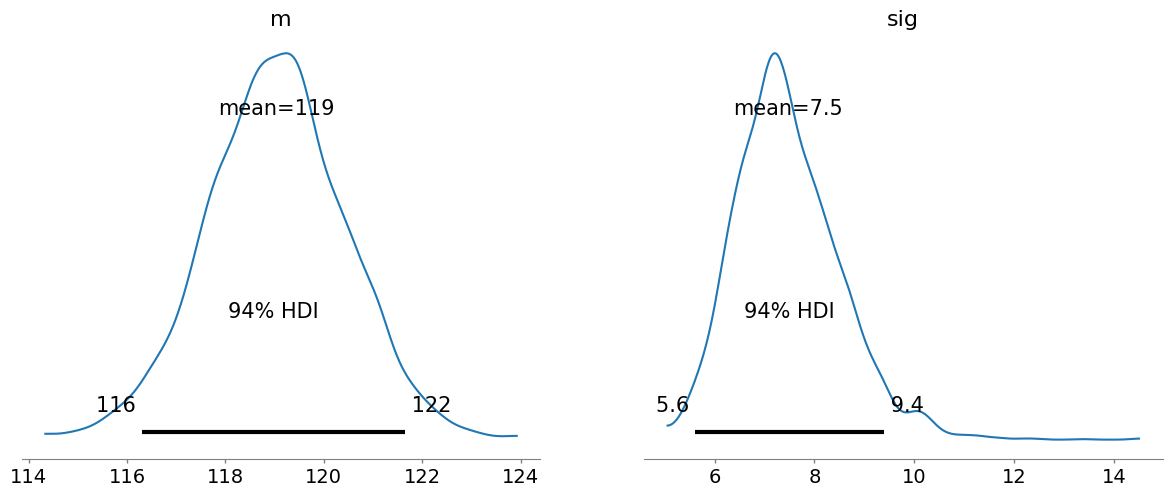

In [ ]:
#plotting the posterior with the HDI
az.plot_posterior(idata_g)

plt.savefig("hdi.png", bbox_inches='tight')
files.download("hdi.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

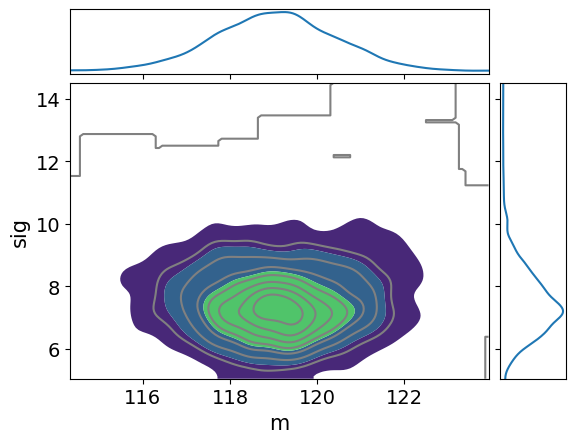

In [ ]:
#joint distribution of mu and sigma
az.plot_pair(idata_g, kind='kde', marginals=True)

plt.savefig("pair.png", bbox_inches='tight')
files.download("pair.png")

In [ ]:
#statistics
az.summary(idata_g, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
m,121.11,1.39,118.62,123.98
sig,7.29,1.04,5.45,9.20


Prior Predictive

In [ ]:
with model_g:
  prior_predictive = pm.sample_prior_predictive(1000)

prior_predictive

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

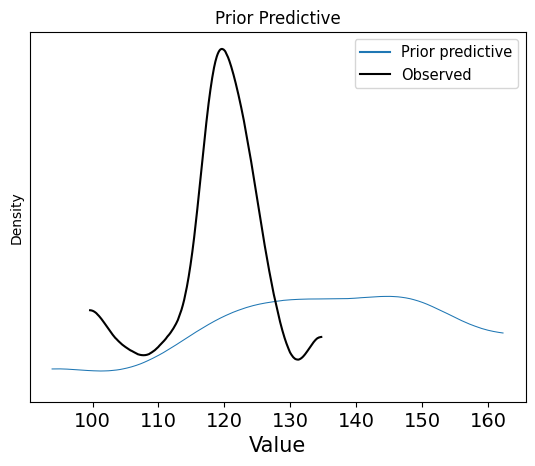

In [ ]:
#plotting prior predictive
ax = az.plot_ppc(prior_predictive, group='prior', num_pp_samples=1, mean=False, observed=True, random_seed=14)
ax.get_lines()[2].set_alpha(1.0)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Prior Predictive')

plt.savefig("prior_predictive.png", bbox_inches='tight')
files.download("prior_predictive.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1000x600 with 0 Axes>

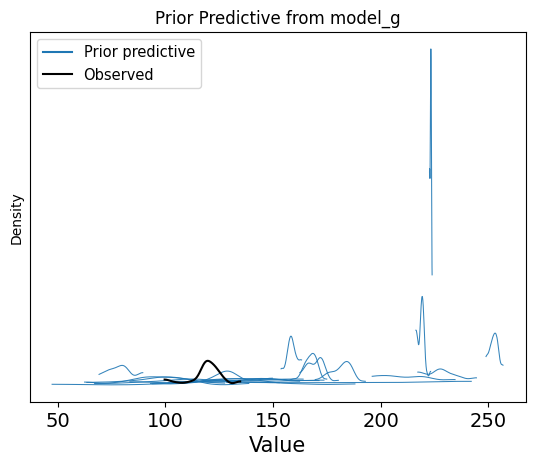

In [ ]:
#a lot of examples
plt.figure(figsize=(10, 6))
ax = az.plot_ppc(prior_predictive, group='prior', num_pp_samples=20, mean=False, observed=True, random_seed=14)

for l in ax.get_lines()[2:]:
    l.set_alpha(0.9)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Prior Predictive from model_g')

plt.savefig("prior_predictive2.png", bbox_inches='tight')
files.download("prior_predictive2.png")


Posterior Predictive

In [ ]:
#sampling and adding the posterior predictive data to the inference data
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

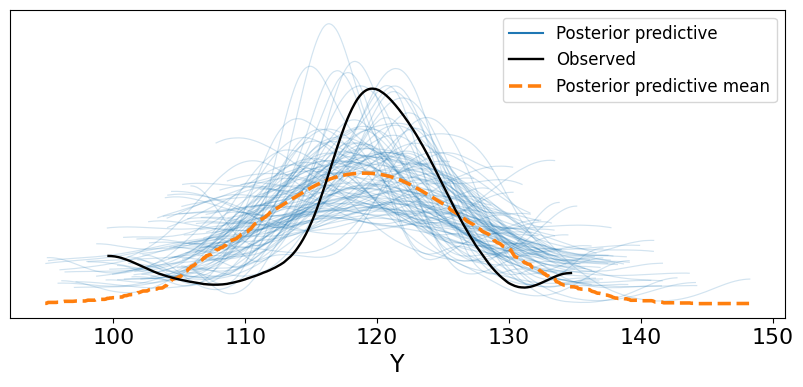

In [ ]:
#plotting
az.plot_ppc(idata_g, figsize=(10, 4), num_pp_samples=100)
plt.savefig("posterior_predictive.png", bbox_inches='tight')
files.download("posterior_predictive.png")

Student's t distribution

(Exponential(lam=0.115), <Axes: >)

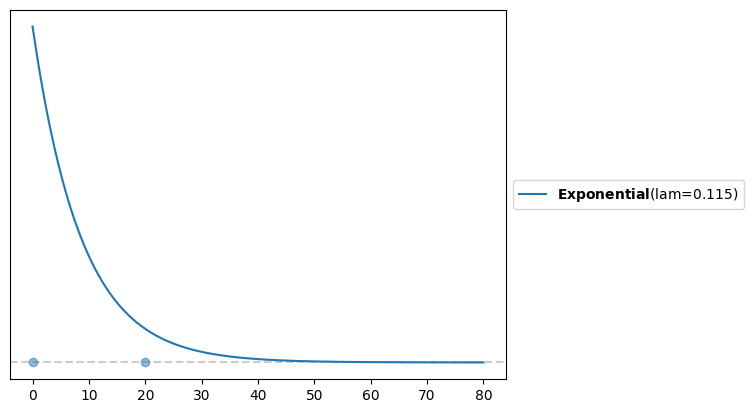

In [4]:
dist = pz.Exponential()
pz.maxent(dist, 0, 20, 0.9)

In [10]:
#model
with pm.Model(coords = coords) as model_t:
  m = pm.Normal('m', mu = mu_prior, sigma = sig_prior)
  sig = pm.HalfNormal('sig', sigma = sigma_prior)
  n = pm.Exponential('n', 1/10)
  Y = pm.StudentT('Y', nu = n, mu=m, sigma=sig, observed=data, dims = 'data')
  idata_t = pm.sample(1000, chains = 4)


Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

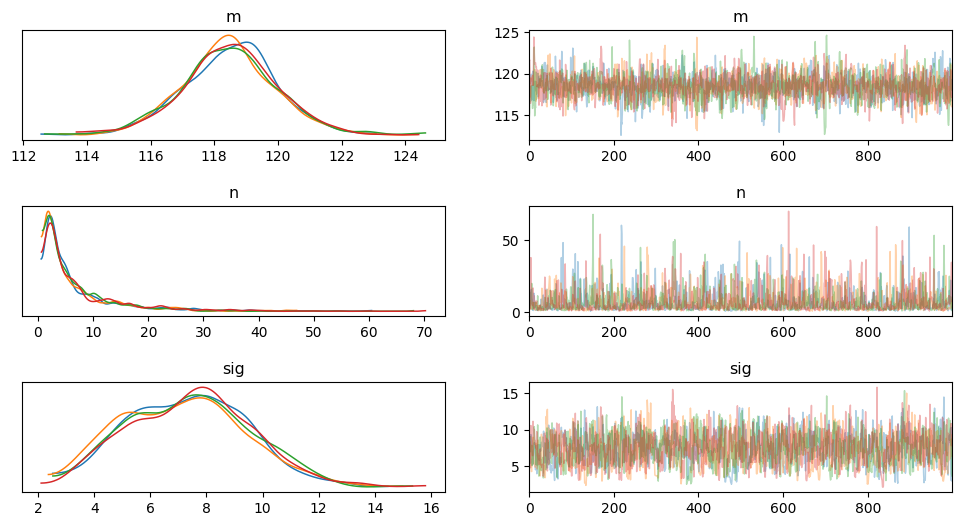

In [12]:
#trace data
az.plot_trace(idata_t, compact = False)
plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots

plt.savefig("tracet.png", bbox_inches='tight')
files.download("tracet.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

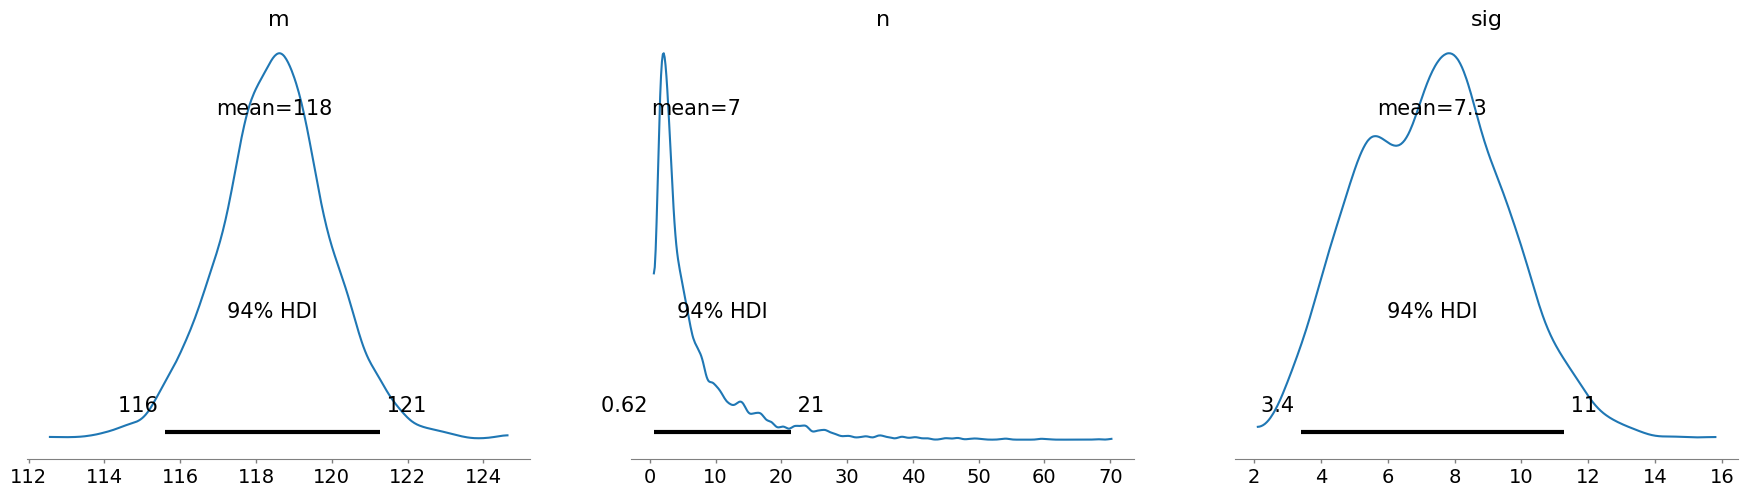

In [13]:
#plotting the posterior with the HDI
az.plot_posterior(idata_t)

plt.savefig("hdit.png", bbox_inches='tight')
files.download("hdit.png")

In [14]:
#statistics
az.summary(idata_t, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
m,118.48,1.51,115.59,121.28
n,6.96,7.62,0.62,21.43
sig,7.33,2.18,3.40,11.27


Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

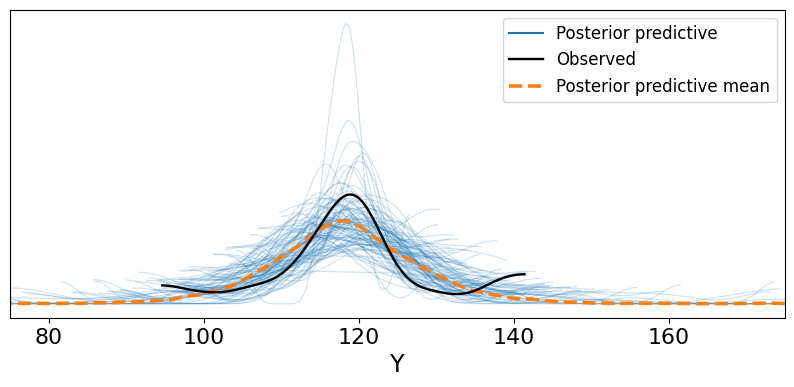

In [36]:
#Posterior predictive check
pm.sample_posterior_predictive(idata_t, model=model_t, extend_inferencedata=True)

az.plot_ppc(idata_t, figsize=(10, 4), num_pp_samples=100)
plt.xlim([75, 175])
plt.savefig("posterior_predictivet.png", bbox_inches='tight')
files.download("posterior_predictivet.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

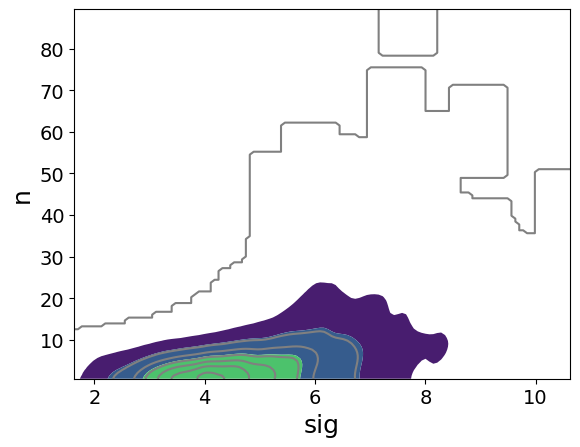

In [ ]:
#showing the correlation between sigma and nu
ax = az.plot_pair(idata_t, var_names=['sig', 'n'], kind='kde', marginals=False)

ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("pair2.png", bbox_inches='tight')
files.download("pair2.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

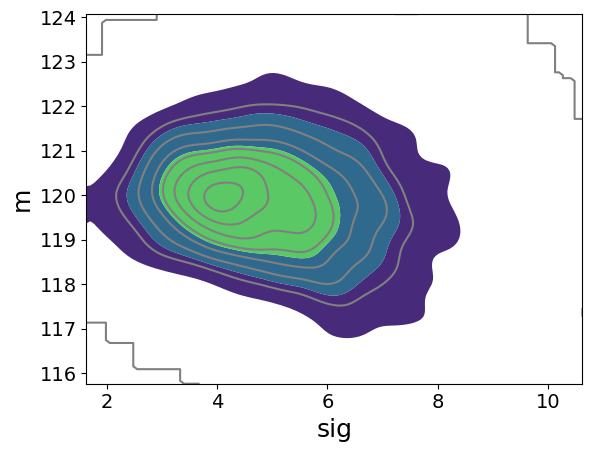

In [ ]:
#but none between mu and sigma
ax = az.plot_pair(idata_t, var_names=['sig', 'm'], kind='kde', marginals=False)

ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.savefig("pair3.png", bbox_inches='tight')
files.download("pair3.png")


## Groups Comparison

In [ ]:
tips = pd.read_csv("https://github.com/aloctavodia/BAP3/raw/refs/heads/main/code/data//tips.csv")
tips.head()
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
#preprocessing
categories = np.array(["Thur", "Fri", "Sat", "Sun"])
bill = tips["total_bill"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

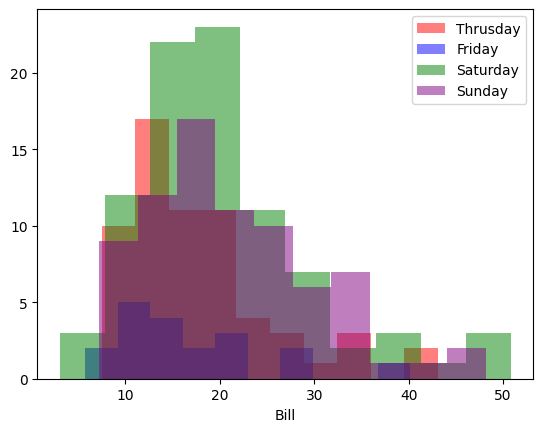

In [ ]:
#plot the data
thurs = tips.total_bill[tips['day'] == 'Thur'].values
fri = tips.total_bill[tips['day'] == 'Fri'].values
sat = tips.total_bill[tips['day'] == 'Sat'].values
sun = tips.total_bill[tips['day'] == 'Sun'].values


plt.hist(thurs, color = 'red', alpha = 0.5, label = 'Thrusday')
plt.hist(fri, color = 'blue', alpha = 0.5, label = 'Friday')
plt.hist(sat, color = 'green', alpha = 0.5, label = 'Saturday')
plt.hist(sun, color = 'purple', alpha = 0.5, label = 'Sunday')
plt.xlabel('Bill')
plt.legend()

plt.savefig("hist.png", bbox_inches='tight')
files.download("hist.png")

(HalfNormal(sigma=60.8), <Axes: >)

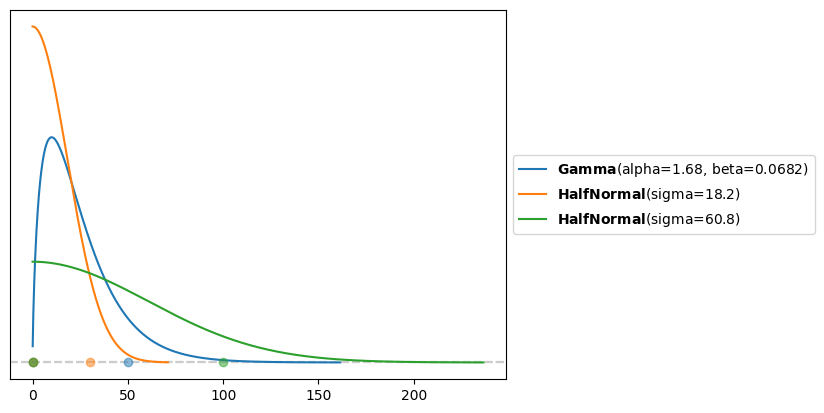

In [ ]:
dist = pz.Gamma()
pz.maxent(dist, 0, 50, 0.9)

dist.alpha/dist.beta
dist.alpha/(dist.beta**2)

dist = pz.HalfNormal()
pz.maxent(dist, 0, 30, 0.9)

dist = pz.HalfNormal()
pz.maxent(dist, 0, 100, 0.9)

In [ ]:
#creating the model
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
  m = pm.HalfNormal("m", sigma = 20, dims="days")
  sig = pm.HalfNormal("sig", sigma=30, dims="days")

  y = pm.Gamma("y", mu=m[idx], sigma=sig[idx], observed = bill, dims = "days_flat")

  idata_cg = pm.sample(1000, chains = 4)
  idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Output()

Output()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

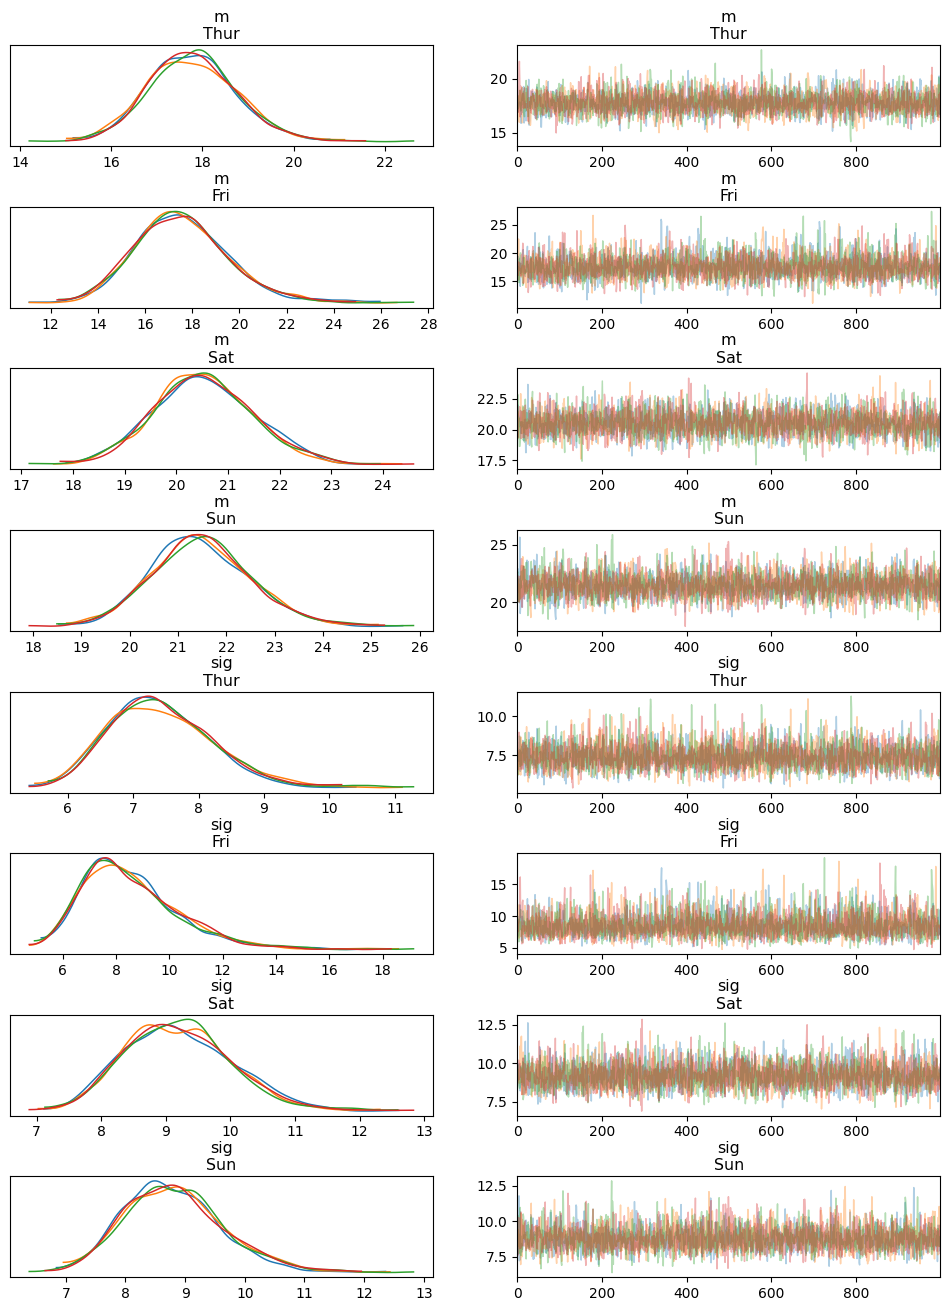

In [ ]:
#trace data
az.plot_trace(idata_cg, compact = False)
plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots

plt.savefig("tracegroup.png", bbox_inches='tight')
files.download("tracegroup.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

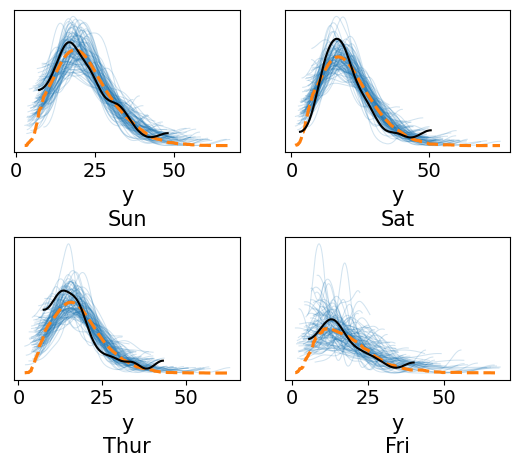

In [ ]:
#posterior predictive
_, axes = plt.subplots(2, 2)
az.plot_ppc(idata_cg, num_pp_samples=100, coords={"days_flat":[categories]}, flatten=[], ax=axes, legend=False)
plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots

plt.savefig("ppc.png", bbox_inches='tight')
files.download("ppc.png")

Cohen's d

In [ ]:
comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]
#print(comparisons)
cg_posterior = az.extract(idata_cg)

for (i, j) in comparisons:
    means_diff = cg_posterior["m"].sel(days=i) - cg_posterior['m'].sel(days=j)

    d_cohen = (means_diff /
               np.sqrt((cg_posterior["sig"].sel(days=i)**2 +
                        cg_posterior["sig"].sel(days=j)**2) / 2)).mean().item()

    print(f"{i} - {j}: cohen's d = {round(d_cohen, 2)}")



Thur - Fri: cohen's d = 0.04
Thur - Sat: cohen's d = -0.33
Thur - Sun: cohen's d = -0.46
Fri - Sat: cohen's d = -0.35
Fri - Sun: cohen's d = -0.46
Sat - Sun: cohen's d = -0.11


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

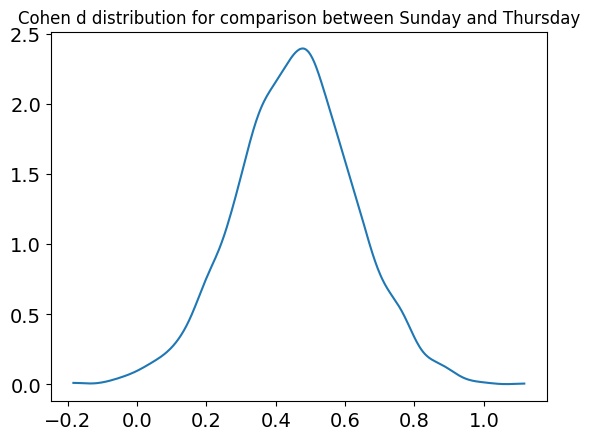

In [ ]:
means_diff = cg_posterior["m"].sel(days='Sun') - cg_posterior['m'].sel(days='Thur')

d_cohen = (means_diff /
          np.sqrt((cg_posterior["sig"].sel(days='Sun')**2 +
                  cg_posterior["sig"].sel(days='Thur')**2) / 2))


az.plot_dist(d_cohen)
plt.title('Cohen d distribution for comparison between Sunday and Thursday')

plt.savefig("cohensd_dist.png", bbox_inches='tight')
files.download("cohensd_dist.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

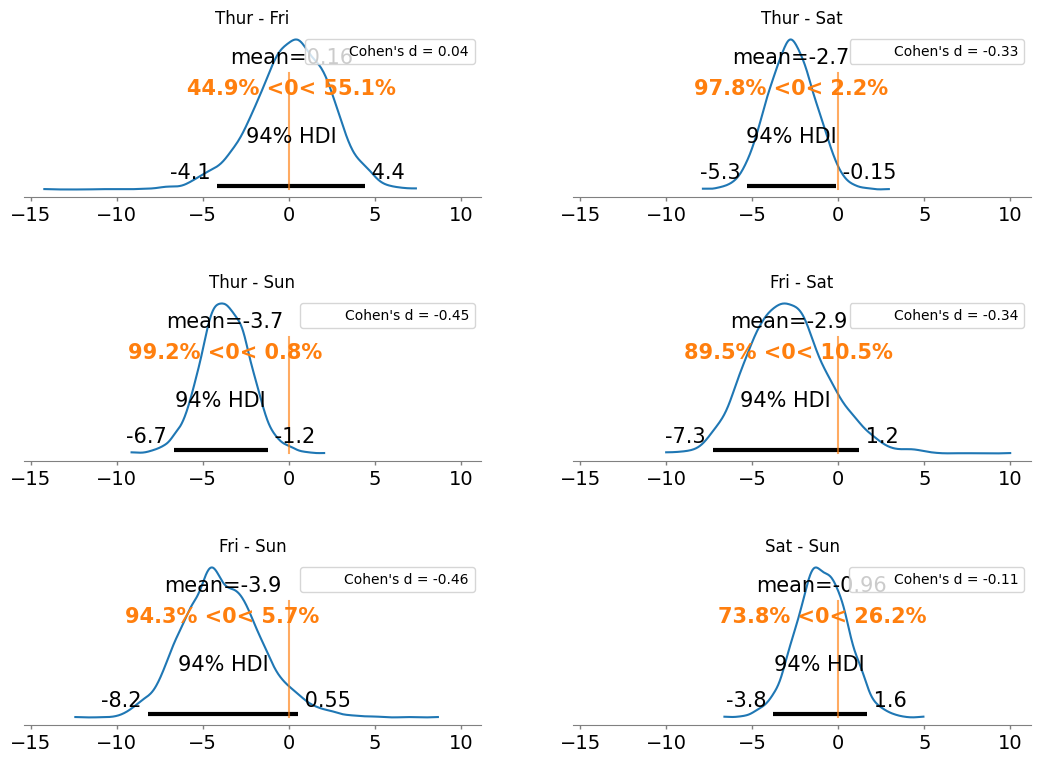

In [ ]:

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["m"].sel(days=i) - cg_posterior['m'].sel(days=j)

    d_cohen = (means_diff /
               np.sqrt((cg_posterior["sig"].sel(days=i)**2 +
                        cg_posterior["sig"].sel(days=j)**2) / 2)).mean().item()

    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}", alpha=0)
    ax.legend(loc=1)

plt.subplots_adjust(hspace=0.6)  # Increase spacing between subplots

plt.savefig("summary.png", bbox_inches='tight')
files.download("summary.png")